In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import os
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim


# Create a folder for results
def create_results_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape, x_test.shape)

# Split data into training and validation sets
val_split = 0.2
val_size = int(len(x_train) * val_split)
x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]

# Apply skeletonization
def apply_skeletonization(images):
    skeletonized_images = []
    for image in images:
        img = (image.squeeze() * 255).astype(np.uint8)
        _, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        skeleton = skeletonize(img_bin // 255)
        skeleton = skeleton.astype(np.float32)
        skeletonized_images.append(skeleton)
    return np.array(skeletonized_images)

# Apply skeletonization to the training, validation, and test sets
x_train_skeleton = apply_skeletonization(x_train)
x_test_skeleton = apply_skeletonization(x_test)
x_val_skeleton = apply_skeletonization(x_val)

# Define the autoencoder with L1 and L2 regularization
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder


# create prototype images for each digit
def create_prototypes_for_each_digit(x_train, y_train, n_clusters=5):
    prototypes = []
    for digit in range(10):
        digit_images = x_train[y_train == digit]
        digit_images_flat = digit_images.reshape((digit_images.shape[0], -1))
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(digit_images_flat)
        cluster_centers = kmeans.cluster_centers_
        cluster_centers_reshaped = cluster_centers.reshape((n_clusters, 28, 28))
        prototypes.append(cluster_centers_reshaped)
    return prototypes

# prepare the training data
def prepare_training_data(x_skeleton, prototypes, y_labels):
    y_train_prepared = []
    for i, label in enumerate(y_labels):
        proto_digit = prototypes[label]
        random_proto = proto_digit[np.random.randint(0, len(proto_digit))]
        y_train_prepared.append(random_proto)
    y_train_prepared = np.array(y_train_prepared)
    y_train_prepared = np.expand_dims(y_train_prepared, -1)
    return x_skeleton, y_train_prepared

prototypes = create_prototypes_for_each_digit(x_train.squeeze(), y_train)

x_train_prepared, y_train_prepared = prepare_training_data(x_train_skeleton, prototypes, y_train)
x_test_prepared, y_test_prepared = prepare_training_data(x_test_skeleton, prototypes, y_test)

# Function to visualize prototypes
def visualize_prototypes(prototypes, results_folder):
    plt.figure(figsize=(10, 5))
    num_prototypes = len(prototypes)
    for i in range(num_prototypes):
        plt.subplot(2, num_prototypes, i + 1)
        plt.imshow(prototypes[i].squeeze(), cmap='gray')
        plt.title(f'Prototype {i}')
        plt.axis('off')
    plt.savefig(os.path.join(results_folder, "prototypes.png"))
    plt.close()

(60000, 28, 28, 1) (10000, 28, 28, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.2757 - loss: 0.4543 - val_accuracy: 0.2778 - val_loss: 0.2891
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2779 - loss: 0.2868 - val_accuracy: 0.2778 - val_loss: 0.2778
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.2779 - loss: 0.2771 - val_accuracy: 0.2778 - val_loss: 0.2706


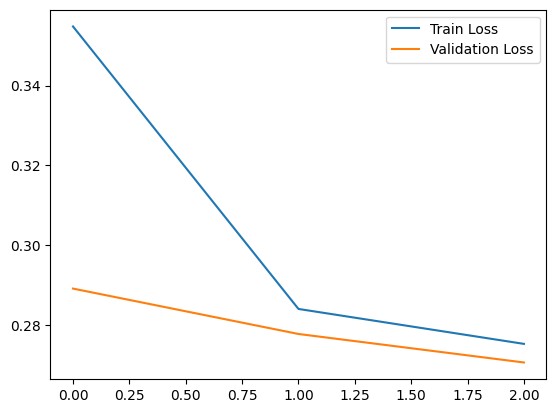

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
SSIM: 0.3198202861080829


In [2]:
# Build and compile the autoencoder 
autoencoder = build_autoencoder(input_shape=(28, 28, 1))
autoencoder.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the autoencoder
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(x_train_prepared, y_train_prepared,
                          epochs=30,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_prepared, y_test_prepared))


results_folder = create_results_folder("resultsforPROTOTYPES_with_regularization_3_128_0002")

# Save the autoencoder
autoencoder.save(os.path.join(results_folder, "autoencoder.keras"))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.savefig(os.path.join(results_folder, "loss.png"))
plt.show()

# visualize the results
def visualize_results(x_test, x_test_skeleton, decoded_imgs, y_test_prepared, results_folder):
    plt.figure(figsize=(15, 10))
    num_digits = 10
    indices = [np.where(y_test == i)[0][0] for i in range(num_digits)]  
    
    for i in range(num_digits):
        index = indices[i]
        
        plt.subplot(4, num_digits, i + 1)
        plt.imshow(x_test[index].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(4, num_digits, i + 1 + num_digits)
        plt.imshow(x_test_skeleton[index].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(4, num_digits, i + 1 + 2 * num_digits)
        plt.imshow(y_test_prepared[index].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(4, num_digits, i + 1 + 3 * num_digits)
        plt.imshow(decoded_imgs[index].squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.savefig(os.path.join(results_folder, "examples_with_prototypes.png"))
    plt.close()

# Generate images using the trained autoencoder
decoded_imgs = autoencoder.predict(x_test_skeleton)
visualize_results(x_test, x_test_skeleton, decoded_imgs, y_test_prepared, results_folder) 

# Calculate SSIM (Structural Similarity Index) between original and generated images
def calculate_ssim(original_images, generated_images):
    ssim_values = []
    for orig, gen in zip(original_images, generated_images):
        ssim_val = ssim(orig.squeeze(), gen.squeeze(), data_range=gen.max() - gen.min())
        ssim_values.append(ssim_val)
    return np.mean(ssim_values)

# Calculate SSIM between original and generated images
ssim_value = calculate_ssim(x_test, decoded_imgs)
print(f'SSIM: {ssim_value}')

# Save the results of SSIM and hyperparameters
hyperparameters = {
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 20,
    "dropout": 0,
    "batch_size": 128,
    "learning ratio": 0.0002,
    "l1_regularizer": 1e-5,
    "l2_regularizer": 1e-4
}

with open(os.path.join(results_folder, "results.txt"), "w") as file:
    file.write(f"SSIM: {ssim_value}\n")
    file.write("Hyperparameters:\n")
    for key, value in hyperparameters.items():
        file.write(f"{key}: {value}\n")